# Criteria air pollutants in Mexico City monitored since 1986

This document explains the Data Science workflow I went through, from extracting _open data_ to comunicating my conclusions, regarding the criteria pollutants and their impact on air quality and public health.

## Data Science Workflow
<img src="https://ismayc.github.io/moderndiver-book/images/tidy1.png" alt="Data Science Workflow import tidy transform understand communicate" title="Data_Science_Workflow" width="400" />

# 1. Objective
Determine wether **no-driving days** have improved air quality in Mexico City and if there has been also an improvement in public health. Policy makers may find the results useful and evaluate the neccesity of implementing these kind of measurments in other fast-growing cities like Monterrey or Guadalajara.

# 2. Extracting and loading data
Look at the [criteria air pollutants in Mexico City data](http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmI=%27&opcion=Zg==) and notice that:
1. Files store pollutants since 1986 up to date.
2. Headers are inconsistant among files.
3. Observations start at row 11.

To read the data, one should:
1. Create _list comprehensions_ `list_comps` by reading the csv files, starting at row 11 without headers for each `url_name` beginning at 1986.
2. Concatenate the lists into a single Data Frame `df`.
3. Create a list `col_names` that contains relevant variable names.
4. Assign the `col_names` to the Data Frame columns `df.columns`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

url_name = 'http://148.243.232.112:8080/opendata/anuales_horarios/contaminantes_{}.csv'

In [2]:
list_comps = [pd.read_csv(url_name.format(i), skiprows=11, header=None) for i in range(1986, 2019)]
df = pd.concat(list_comps)
col_names = ['date', 'station', 'pollutant', 'concentration', 'unit']
df.columns = col_names

## 3. Exploratory data analysis (EDA)
Use the `head()`, `tail()`and `info()` methods to perform an EDA.

In [3]:
df.head()

,date,station,pollutant,concentration,unit
0,01/01/1986 01:00,LAG,CO,NaN,15
1,01/01/1986 01:00,TLA,CO,NaN,15
2,01/01/1986 01:00,XAL,CO,NaN,15
3,01/01/1986 01:00,MER,CO,NaN,15
4,01/01/1986 01:00,PED,CO,NaN,15


In [4]:
df.tail()

,date,station,pollutant,concentration,unit
1405507,31/08/2018 24:00,INN,PM2.5,NaN,2
1405508,31/08/2018 24:00,INN,PMCO,NaN,2
1405509,31/08/2018 24:00,INN,SO2,NaN,1
1405510,31/08/2018 24:00,GAM,O3,26.0,1
1405511,31/08/2018 24:00,GAM,PM2.5,12.0,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36994584 entries, 0 to 1405511
Data columns (total 5 columns):
date             object
station          object
pollutant        object
concentration    float64
unit             int64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ GB


In [6]:
df.shape

(36994584, 5)

These methods show that:
- The data is tidy.
- The `date` column contains date time information as dtype `object`, i.e., it is stored as text `string` instead of a `datetime64`.
- The dates are written in a `day/month/year hour:minute` format. 
- Some dates are written in a 24-hour format which will raise an error when appling `pd.to_datetime` to the column `date`.
- Many concentration values were imported as *Not a Number* (`NaN`) when there were no pollutants in the air (`value=0`).

These are the first issues that require a cleaning treatment.

## 4. Cleaning data
### 4.1 Datetime index
To solve the format problem in the `date` column:
1. Use `str.replace()` vectorized function to replace all 24:00 observations with 23:59, that is, substract one minute.
2. Convert the date `object` to `datetime64` with the pandas `to_datetime` function so that calculations can be performed. Include `format="%d/%m/%Y %H:%M"` to speed up the convertion.
3. Set the new date column as the index of the dataframe with the `set_index` function specifing `inplace=True`.


In [7]:
df.date = df.date.str.replace('24:00', '23:59')
df.date = pd.to_datetime(df.date, format="%d/%m/%Y %H:%M")
df.set_index('date', inplace=True)

### 4.2 Missing values
One can find out also the _missing values_ in all columns, that is, the number of values that were recorded as `NaN` instead of 0.

To do so, let's chain `isnull().sum()` methods to the complete dataframe.

In [8]:
df.isnull().sum()

station                0
pollutant              0
concentration    6604964
unit                   0
dtype: int64

Here, one can see that `'concentration'` is the only column containing missing values.

In [9]:
missing_vals = df[df.concentration.isnull()]
missing_vals.shape

(6604964, 4)

One can assume the concentration of pollutants was null for those moments, so it is possible to fill in the missing values (`NaN`) with 0 by applying `fillna(0)` method and specifying `inplace=True`.

Then, let's review again the `head()`, `tail()`and `info()` methods.

In [10]:
df.concentration.fillna(0, inplace=True)
df.head()

,station,pollutant,concentration,unit
date,,,,
1986-01-01 01:00:00,LAG,CO,0.0,15
1986-01-01 01:00:00,TLA,CO,0.0,15
1986-01-01 01:00:00,XAL,CO,0.0,15
1986-01-01 01:00:00,MER,CO,0.0,15
1986-01-01 01:00:00,PED,CO,0.0,15


In [11]:
df.tail()

,station,pollutant,concentration,unit
date,,,,
2018-08-31 23:59:00,INN,PM2.5,0.0,2
2018-08-31 23:59:00,INN,PMCO,0.0,2
2018-08-31 23:59:00,INN,SO2,0.0,1
2018-08-31 23:59:00,GAM,O3,26.0,1
2018-08-31 23:59:00,GAM,PM2.5,12.0,2


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36994584 entries, 1986-01-01 01:00:00 to 2018-08-31 23:59:00
Data columns (total 4 columns):
station          object
pollutant        object
concentration    float64
unit             int64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.4+ GB


In [13]:
df.shape

(36994584, 4)

Let's chain `isnull().sum()` methods to the complete dataframe to check out for missing values one last time.

In [14]:
df.isnull().sum()

station          0
pollutant        0
concentration    0
unit             0
dtype: int64

The last results verify that there aren't missing values anymore. So let's move on to a visual exploratory data analysis with this new dataframe.
## Visual Exploratory Data Analysis (Visual EDA)
Plot the concentration of pollutants as a time series to visualize the data.

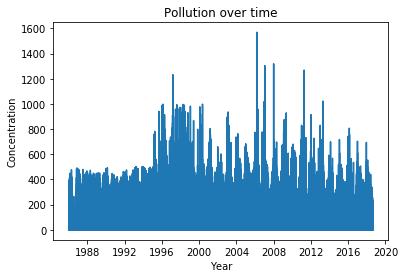

In [15]:
%matplotlib inline

mpl.rcParams['agg.path.chunksize'] = 10000

plt.plot(df.concentration)
plt.title("Pollution over time")
plt.xlabel("Year")
plt.ylabel("Concentration")
plt.show()

In accordance with the [Air Quality Index Standard](http://www.aire.cdmx.gob.mx/descargas/monitoreo/normatividad/NADF-009-AIRE-2006.pdf), one has to apply some equations of transformation to the `concentration` values depending on the `unit` and `pollutant` to get a standard scale for all the pollutants.

To do so, first one should see which values are used for units.

In [16]:
df.unit.value_counts()

1     25317768
15     6099744
2      5577072
Name: unit, dtype: int64

One can see that `unit` contains only 1, 2 and 15 values as categories when applying `value_counts()` method.<br>
Let's do the same for the pollutants.

In [17]:
df.pollutant.value_counts()

SO2      6647376
CO       6099744
O3       5760768
NO2      4878816
NOX      4878816
PM10     3239328
NO       3151992
PM2.5    1673496
PMCO      664248
Name: pollutant, dtype: int64

Now let's use a scatter plot to visualise the relationship between pollutants and the units that meassure their concentrations.

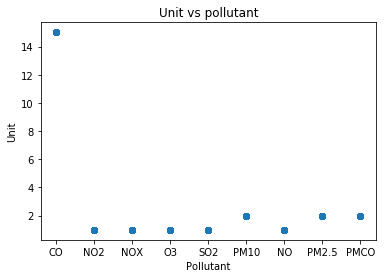

In [18]:
plt.scatter(df.pollutant, df.unit)
plt.title("Unit vs pollutant")
plt.xlabel("Pollutant")
plt.ylabel("Unit")
plt.show()

Here one can see that:
* Only CO is represented by unit 15.
* PM10, PM2.5 and PMCO are represented by unit 2.
* The rest, including nitrogen oxides (NO2, NOX and NO) are represented by unit 1.

Observations:
* PMCO is not a pollutant. Since it uses unit 2 as the other _Particulated Matter_ (PM), one can supose the correct name is either PM10 or PM2.5 so I will choose PM10.
* NOX is not a clear pollutant name. It could refer to NO or NO2. Besides, it seems like NOX and NO2 are duplicates since they both show the same value 4878816 according to `value_counts()` method.

In [19]:
df_PMCO = df[df.pollutant=='PMCO']

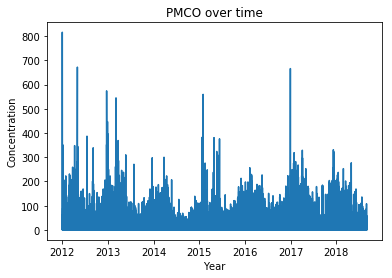

In [20]:
plt.plot(df_PMCO.concentration)
plt.title("PMCO over time")
plt.xlabel("Year")
plt.ylabel("Concentration")
plt.show()

In [21]:
df_NOX = df[df.pollutant=='NOX']

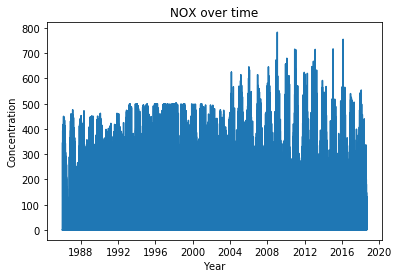

In [22]:
plt.plot(df_NOX.concentration)
plt.title("NOX over time")
plt.xlabel("Year")
plt.ylabel("Concentration")
plt.show()